In [89]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [90]:
# Global grids area
nlon = 72
nlat = 45
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-88, 92, 4)
res = 4;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

## Analysis of single site simulation

In [118]:
############################################################
### Pick a site for analysis
############################################################

## Inpyts from user
## Some constants
yr_beg = 1850
nyr_spinup = 113
nyr_transient = 6 

# grid area in m2
# This number shall be calculated for a given latitude and longitude
lon_pos = 22
lat_pos = 35

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in_spinup = 'testluc.cori-haswell.E4f9ce69d2-F2d2a755c.2022-04-18.elm.h0.spinup.nc'
filename_in_spinup = 'testluc.cori-haswell.E4f9ce69d2-F2d2a755c.2022-04-23.elm.h0.spinup.nc'
filename_in_transient = 'testluc.cori-haswell.E4f9ce69d2-F2d2a755c.2022-04-18.elm.h0.transient_1850_1855.nc'
site_area = grid_area[lat_pos, lon_pos]

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in_spinup)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]
cohort_size_bins = fin.variables['fates_levscls'][:]

## define the sizes of each dimension
ntim_spinup = len(time)
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## read in variables
vegc_spinup = fin.variables['FATES_VEGC'][:]   # kgc m-2
gpp_spinup = fin.variables['FATES_GPP'][:]   # kgc m-2 s-1
npp_spinup = fin.variables['FATES_NPP'][:]   # kgc m-2 s-1
biomass_pf_spinup = fin.variables['FATES_VEGC_PF'][:]  # kgc m-2 [SZxPFT]
area_ag_spinup = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_spinip = fin.variables['FATES_NPATCHES'][:]
ncohort_spinip = fin.variables['FATES_NCOHORTS'][:]
fin.close()

## Transient history
# Daily output
fin = nc.netcdf_file(filename_in_transient)

## read the coordinate data for the various dimensions
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years

## define the sizes of each dimension
ntim_transient = len(time)

## read in variables
vegc_transient = fin.variables['FATES_VEGC'][:]   # kgc m-2
# gpp_transient = fin.variables['FATES_GPP'][:]   # kgc m-2 s-1
# npp_transient = fin.variables['FATES_NPP'][:]   # kgc m-2 s-1
biomass_szpf_transient = fin.variables['FATES_VEGC_SZPF'][:]  # kgc m-2 [SZxPFT]
area_ag_transient = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
hrv_flux10c_transient = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]   # kgc m-2 s-1
hrv_flux100c_transient = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]   # kgc m-2 s-1
hrv_10c_transient = fin.variables['PROD10C'][:]   # kgc m-2
hrv_100c_transient = fin.variables['PROD100C'][:]   # kgc m-2
fin.close()

## Auxiliary data: land use time series
filename_in_luinput = 'landuse.timeseries_1x1_brazil_hist_simyr1850-2015_c200310_biomass_harvest.nc' 
# One boreal site
# filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015.testluc_biomass_harvest.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
lu_hrv_frac = fin_luinput.variables['HARVEST_VH1_FRAC'][:]+fin_luinput.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_c = fin_luinput.variables['HARVEST_VH1'][:]+fin_luinput.variables['HARVEST_VH2'][:]
fin_luinput.close()

# biomass_den = np.nanmean(biomass_wthrv, 1)
# biomass_den = np.nansum(biomass_wthrv*area_age_wthrv, 1)
# ## because the bin edges read in define the lower edges, add a last index to each to
# ## represent the upper edge of the distribution (even though there isn't one, really)
# patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
# cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)

Text(0.5,1,'Site XX Productivities')

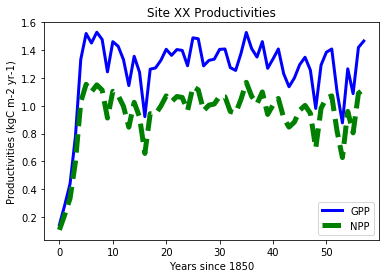

In [8]:
## Check spinup history + transient case for productivity
## For transient case the daily data are transferred into annual
gpp_yr = np.zeros((nyr_spinup))
npp_yr = np.zeros((nyr_spinup))
for iyr in np.arange(0,nyr_spinup):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    gpp_yr[iyr] = np.nanmean(gpp_spinup[id_beg:id_end])*3600*24*365
    npp_yr[iyr] = np.nanmean(npp_spinup[id_beg:id_end])*3600*24*365

plt.plot(gpp_yr, 'b-', linewidth=3)
plt.plot(npp_yr, 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Productivities (kgC m-2 yr-1)')
plt.legend(['GPP', 'NPP'])
plt.title('Site XX Productivities')
# plt.savefig('validate_cbased_luc_frac.png')

Text(0.5,1,'Site XX Vegetation C from FATES')

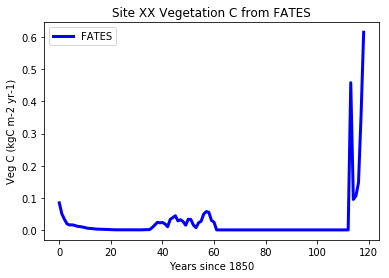

In [93]:
## Validate total biomass
# Annual mean, spinup + transient
veg_c_yr = np.zeros((nyr_spinup+nyr_transient))
for iyr in np.arange(0,nyr_spinup):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    veg_c_yr[iyr] = np.nanmean(vegc_spinup[id_beg:id_end])
    npatch_yr[iyr] = np.nanmean(npatch_spinip[id_beg:id_end])
for iyr in np.arange(0,nyr_transient):
    id_beg = iyr*365
    id_end = (iyr+1)*365-1
    veg_c_yr[nyr_spinup+iyr] = np.nanmean(vegc_transient[id_beg:id_end])

# Density * area * natural land fraction
veg_c_mass_yr = veg_c_yr * site_area * np.nansum(area_ag_spinup[0,:,0])

plt.plot(veg_c_yr, 'b-', linewidth=3)
# plt.plot(veg_c_mass_yr[58:58+nyr_transient], 'b-', linewidth=5)
# plt.plot(lu_hrv_c[0:nyr_transient,0,0], 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Veg C (kgC m-2 yr-1)')
plt.legend(['FATES', 'LUH2'])
plt.title('Site XX Vegetation C from FATES')
# plt.savefig('validate_cbased_hrv_c.png')

Text(0.5,1,'Site XX Vegetation C from FATES')

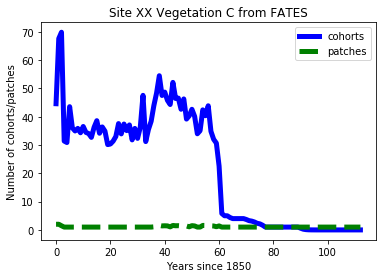

In [119]:
## Validate biomass from different PFTs
biomass_pf_yr = np.zeros((nyr_spinup, 2))
npatch_yr = np.zeros((nyr_spinup))
ncohort_yr = np.zeros((nyr_spinup))
for iyr in np.arange(0,nyr_spinup):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    npatch_yr[iyr] = np.nanmean(npatch_spinip[id_beg:id_end])
    ncohort_yr[iyr] = np.nanmean(ncohort_spinip[id_beg:id_end])
    biomass_pf_yr[iyr,0] = np.nansum(np.nanmean(biomass_pf_spinup[id_beg:id_end,1,0], 0), 0)
    biomass_pf_yr[iyr,1] = np.nansum(np.nanmean(biomass_pf_spinup[id_beg:id_end,11,0], 0), 0)

# plt.plot(biomass_pf_yr[:,0], 'b-', linewidth=5)
# plt.plot(biomass_pf_yr[:,1], 'g--', linewidth=5)
plt.plot(ncohort_yr, 'b-', linewidth=5)
plt.plot(npatch_yr, 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Number of cohorts/patches')
plt.legend(['cohorts', 'patches'])
# plt.ylabel('Veg C (kgC m-2 yr-1)')
# plt.legend(['Woody', 'Non-woody'])
plt.title('Site XX Vegetation C from FATES')

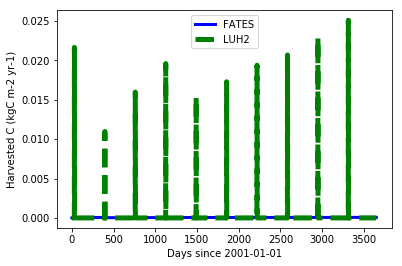

In [9]:
hrv_pool_nohrv = hrv_flux10c_nohrv_elm + hrv_flux100c_nohrv_elm
hrv_pool_wthrv = hrv_flux10c_wthrv_elm + hrv_flux100c_wthrv_elm
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C (gC m-2)')
plt.legend(['Spike', 'Uniform'])

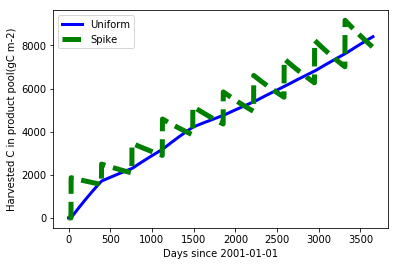

In [13]:
hrv_c_nohrv = hrv_10c_nohrv + hrv_100c_nohrv
hrv_c_wthrv = hrv_10c_wthrv + hrv_100c_wthrv
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C in product pool(gC m-2)')
plt.legend(['Uniform', 'Spike'])
plt.savefig('comparison_uniform_vs_spike.png')

Text(0.5,1,'Check total biomass')

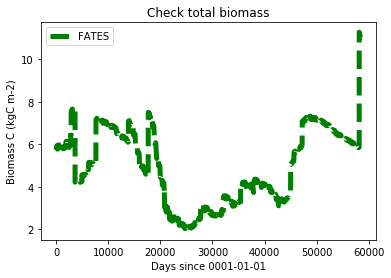

In [13]:
# Check total biomass
plt.plot(biomass_den, 'g--', linewidth=5)
plt.xlabel('Days since 0001-01-01')
plt.ylabel('Biomass C (kgC m-2)')
plt.legend(['FATES'])
plt.title('Check total biomass')